# Test

Statistiken/Daten:
https://data.oecd.org/ict/internet-access.htm
https://data.oecd.org/hha/household-spending.htm
https://data.oecd.org/broadband/households-with-broadband-access.htm
https://data.oecd.org/eduresource/private-spending-on-education.htm
https://data.oecd.org/eduresource/public-spending-on-education.htm
https://en.wikipedia.org/wiki/List_of_countries_by_number_of_households

Korrelationsmatrix um Märkte zu identifizieren die Deutschland ähnlich sind:

U.a. Normalisierung undabhängiger Variablen (5.)
https://towardsdatascience.com/7-steps-to-run-a-linear-regression-analysis-using-r-d5897a66b835

Linear Regression Model Accurancy
http://www.sthda.com/english/articles/40-regression-analysis/167-simple-linear-regression-in-r/

Correlation Matrix
https://www.displayr.com/how-to-create-a-correlation-matrix-in-r/

Idee 1 - vergleichbare Märkte finden:
Deutschland als Erfolgreicher Mark etabliert, ähnliche Märkte sollen gefunden werden.
Zunächst werden die Faktoren, Parameter bestimmt die für Erfolg/Nicht Erfolg verantwortlich sind.
Faktoren: Internetzugriff, Bildungsausgaben, usw -> Korrelationsmatrix (3D) mit Deutschland als Mittelwert 
                                                                                   andere Länder werden damit verglichen (Varianzanalyse)
                                                                                   wenn Werte zu 95% darin liegen (Nullhypothese, Konfidenzintervall)
Ergebnis: Liste mit 10 Kandidaten (Varianz(-bereich))

Idee 2 - Preisberechnung:
Ausgehen vom Preis in Deutschland von 12€/a wird der Anteil der Haushaltsausgaben in Prozent berechnet:
PercentageApp = AppPrice/((Houshold spendings*ExchangeFactor$€)/(Houshold number))
-> 0,00025%
Für alle 10 Kandidaten nun  AppPrice=0,00025%*(Houshold spendings)

In [1]:
library(tidyverse)
library(httr)
library(XML)
library(stringr)

options(jupyter.plot_scale=1)

── Attaching packages ────────────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.5     ✔ purrr   0.3.4
✔ tibble  3.1.6     ✔ dplyr   1.0.7
✔ tidyr   1.1.4     ✔ stringr 1.4.0
✔ readr   2.1.1     ✔ forcats 0.5.1

── Conflicts ───────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()



Download Dataset from OECD website and store them in data frames

In [2]:
# download datasets and store them in dataframes
df_internet_access <- read.csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.INTERNET.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en", header=TRUE)
df_household_spendings <- read.csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.HHEXP.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en", header=TRUE)

#donwload table for alpha-3 to country name mapping
url <- "https://www.iban.com/country-codes"
r <- GET(url)
doc <- readHTMLTable(doc=content(r, "text"))
df_country_codes <- doc[[1]]
# rename column for merging
names(df_country_codes)[3] <- "LOCATION"
df_country_codes <- subset(df_country_codes, select=c(Country,LOCATION))

# merge dataframes for actual country names
df_internet_access <- merge(df_internet_access, df_country_codes,by=c("LOCATION"))
df_household_spendings <- merge(df_household_spendings, df_country_codes,by=c("LOCATION"))

df_internet_access <- subset(df_internet_access, TIME >= 2005)
df_household_spendings <- subset(df_household_spendings, TIME >= 2005)

In [3]:
head(df_internet_access)

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag.Codes,Country
,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<fct>,<fct>
1,AUS,INTERNET,TOT,PC_HH,A,2005,60.00,D,Australia
2,AUS,INTERNET,TOT,PC_HH,A,2006,64.00,D,Australia
3,AUS,INTERNET,TOT,PC_HH,A,2007,67.00,D,Australia
4,AUS,INTERNET,TOT,PC_HH,A,2008,72.00,D,Australia
5,AUS,INTERNET,TOT,PC_HH,A,2010,78.92,D,Australia
6,AUS,INTERNET,TOT,PC_HH,A,2012,83.00,D,Australia


In [4]:
head(df_household_spendings)

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag.Codes,Country
,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<fct>,<fct>
1,AUS,HHEXP,TOT,AGRWTH,A,2011,2.857574e+00,,Australia
9,AUS,HHEXP,TOT,AGRWTH,A,2015,2.555233e+00,,Australia
14,AUS,HHEXP,TOT,AGRWTH,A,2016,2.413756e+00,,Australia
16,AUS,HHEXP,TOT,AGRWTH,A,2012,1.879656e+00,,Australia
19,AUS,HHEXP,TOT,MLN_USD,A,2019,6.756491e+05,,Australia
24,AUS,HHEXP,TOT,AGRWTH,A,2020,9.070364e-01,,Australia


# Normalize and display Internet Access data set

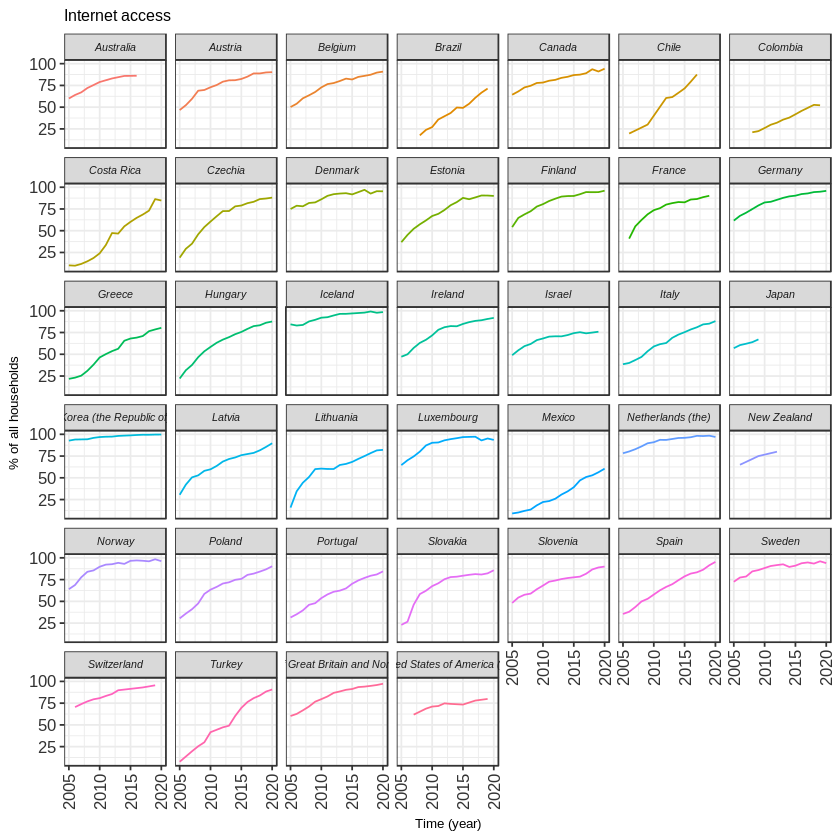

In [5]:
# filter out not usable rows
df_internet_access <- df_internet_access[lapply(df_internet_access,length)>0]

# plotting each country in one plot
ggplot(data = df_internet_access, mapping = aes(x = TIME, y = Value, color = Country)) +
    geom_line() +
    facet_wrap(vars(Country)) +
    labs(title = "Internet access",
        x = "Time (year)",
        y = "% of all households") +
    theme_bw() +
    theme(axis.text.x = element_text(colour = "grey20", size = 10, angle = 90, hjust = 0.5, vjust = 0.5),
                        axis.text.y = element_text(colour = "grey20", size = 10),
                        strip.text = element_text(face = "italic"),
                        text = element_text(size = 8)) +
    theme(legend.position = "none")


# Normalize and display Household Spendings dataset

,LOCATION,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME,Value,Flag.Codes,Country
,<fct>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<fct>,<fct>
19,AUS,HHEXP,TOT,MLN_USD,A,2019,675.6491,,Australia
45,AUS,HHEXP,TOT,MLN_USD,A,2018,686.3800,,Australia
114,AUS,HHEXP,TOT,MLN_USD,A,2017,660.1249,,Australia
150,AUS,HHEXP,TOT,MLN_USD,A,2011,533.3479,,Australia
151,AUS,HHEXP,TOT,MLN_USD,A,2012,549.9631,,Australia
152,AUS,HHEXP,TOT,MLN_USD,A,2013,585.1136,,Australia


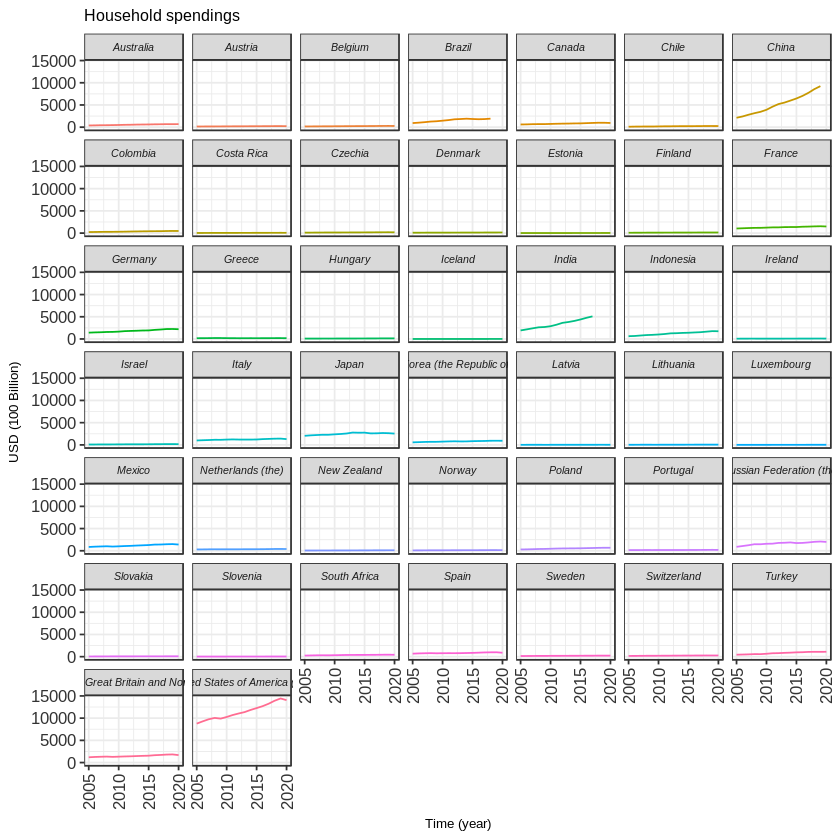

In [6]:
df_household_spendings <- df_household_spendings[lapply(df_household_spendings,length)>0]
df_household_spendings <- subset(df_household_spendings, MEASURE == 'MLN_USD')
df_household_spendings <- subset(df_household_spendings, SUBJECT == 'TOT')
df_household_spendings <- subset(df_household_spendings, TIME >= 2005)
df_household_spendings <- subset(df_household_spendings, LOCATION != 'EU' & LOCATION != 'EA')


df_household_spendings$Value <- df_household_spendings$Value/1000 # 100 Billion USD
head(df_household_spendings)

ggplot(data = df_household_spendings, mapping = aes(x = TIME, y = Value, color = Country)) +
    geom_line() +
    facet_wrap(vars(Country)) +
    labs(title = "Household spendings",
        x = "Time (year)",
        y = "USD (100 Billion)") +
    theme_bw() +
    theme(axis.text.x = element_text(colour = "grey20", size = 10, angle = 90, hjust = 0.5, vjust = 0.5),
                        axis.text.y = element_text(colour = "grey20", size = 10),
                        strip.text = element_text(face = "italic"),
                        text = element_text(size = 8)) +
    theme(legend.position = "none")

### Normalize spending per inhabitant

In [7]:
# Download a table with Population and Household data per country
url <- "https://en.wikipedia.org/wiki/List_of_countries_by_number_of_households"
r <- GET(url)
doc <- readHTMLTable(doc=content(r, "text"))
df_household_numbers <- doc[[2]]

#Rename coulmns to make merging easier
df_household_numbers <- setNames(df_household_numbers, c("Country", "Continent", "Current Population", "NumberInHousehold", 
                                    "Households", "1Member", "2_3Members", "4_5Members", "6Members", "TIME"))

#Clean Time String
df_household_numbers$TIME <- str_replace_all(df_household_numbers$TIME, "\\[2\\]", "")
#Convert Time string to integer 
df_household_numbers$TIME <- as.integer(df_household_numbers$TIME) 
#Remove Not Available Data from Set
df_household_numbers <- na.omit(df_household_numbers)
#Remove Whitspace from Country Names (for merging)
df_household_numbers$Country <- sub("\\W+", "", df_household_numbers$Country)

df_household_numbers <- merge(df_household_numbers, df_country_codes,by="Country")
#head(df_household_numbers)

#Refresh Household Spendings Dataset for Jupyter Cell
df_household_spendings <- read.csv("https://stats.oecd.org/sdmx-json/data/DP_LIVE/.HHEXP.../OECD?contentType=csv&detail=code&separator=comma&csv-lang=en", header=TRUE)
df_household_spendings.mlnusd <- subset(df_household_spendings, MEASURE == 'MLN_USD')
df_household_spendings.mlnusd <- na.omit(df_household_spendings.mlnusd)
#head(df_household_spendings.mlnusd)

#df_spending_per_household <- merge(df_household_numbers, df_household_spendings.mlnusd, by=c("LOCATION", "TIME"))
df_spending_per_household <- merge(df_household_numbers, df_household_spendings.mlnusd, by=c("LOCATION"))

#Prepare String for converting
df_spending_per_household$Households <- str_replace_all(df_spending_per_household$Households, ",", "")
#Convert it to double to do later some calcualtion with it
df_spending_per_household$Households <- as.double(df_spending_per_household$Households)

#Prepare String for converting
df_spending_per_household$NumberInHousehold <- str_replace_all(df_spending_per_household$NumberInHousehold, ",", ".")
#Convert it to double to do later some calcualtion with it
df_spending_per_household$NumberInHousehold <- as.double(df_spending_per_household$NumberInHousehold)

#Calclulate and Add a new Column with Household Spendings to DataFrame
df_spending_per_household$HouseholdSpending <- with(df_spending_per_household, 
                                                    df_spending_per_household$Value*1000000/df_spending_per_household$Households)

#Calclulate and Add a new Column with Per Person Spendings to DataFrame
df_spending_per_household$PerPersonSpending <- with(df_spending_per_household, 
                                                    df_spending_per_household$HouseholdSpending / df_spending_per_household$NumberInHousehold)
head(df_spending_per_household)

Warning message in eval(expr, envir, enclos):
“NAs introduced by coercion”


,LOCATION,Country,Continent,Current Population,NumberInHousehold,Households,1Member,2_3Members,4_5Members,6Members,TIME.x,INDICATOR,SUBJECT,MEASURE,FREQUENCY,TIME.y,Value,Flag.Codes,HouseholdSpending,PerPersonSpending
,<fct>,<chr>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>,<fct>,<int>,<fct>,<fct>,<fct>,<fct>,<int>,<dbl>,<fct>,<dbl>,<dbl>
1,AUS,Australia,Australasia,"25,598,869",2.5,10220186,24.34,49.95,22.44,3.27,2011,HHEXP,TOT,MLN_USD,A,1980,84721.43,,8289.617,3315.847
2,AUS,Australia,Australasia,"25,598,869",2.5,10220186,24.34,49.95,22.44,3.27,2011,HHEXP,TOT,MLN_USD,A,2019,675649.10,,66109.277,26443.711
3,AUS,Australia,Australasia,"25,598,869",2.5,10220186,24.34,49.95,22.44,3.27,2011,HHEXP,TOT,MLN_USD,A,1979,74438.63,,7283.491,2913.396
4,AUS,Australia,Australasia,"25,598,869",2.5,10220186,24.34,49.95,22.44,3.27,2011,HHEXP,TOT,MLN_USD,A,2018,686380.02,,67159.249,26863.700
5,AUS,Australia,Australasia,"25,598,869",2.5,10220186,24.34,49.95,22.44,3.27,2011,HHEXP,TOT,MLN_USD,A,1991,179023.39,,17516.647,7006.659
6,AUS,Australia,Australasia,"25,598,869",2.5,10220186,24.34,49.95,22.44,3.27,2011,HHEXP,TOT,MLN_USD,A,1984,114651.71,,11218.163,4487.265


# Perform linear regression and predict Houshold Spendings for 2021 and 2022


Call:
lm(formula = PerPersonSpending ~ TIME.y + LOCATION, data = df_spending_per_household)

Residuals:
    Min      1Q  Median      3Q     Max 
-6762.8 -1118.9  -318.9   923.7 10494.1 

Coefficients:
              Estimate Std. Error  t value Pr(>|t|)    
(Intercept) -8.708e+05  8.023e+03 -108.531  < 2e-16 ***
TIME.y       4.421e+02  4.019e+00  109.982  < 2e-16 ***
LOCATIONAUT  1.464e+03  3.975e+02    3.684 0.000239 ***
LOCATIONBEL  3.752e+01  3.975e+02    0.094 0.924815    
LOCATIONBRA -1.056e+04  4.990e+02  -21.161  < 2e-16 ***
LOCATIONCAN  2.552e+02  3.975e+02    0.642 0.520992    
LOCATIONCHE  4.148e+03  3.975e+02   10.435  < 2e-16 ***
LOCATIONCHL -8.830e+03  4.802e+02  -18.389  < 2e-16 ***
LOCATIONCHN -1.311e+04  4.634e+02  -28.282  < 2e-16 ***
LOCATIONCOL -1.098e+04  4.863e+02  -22.574  < 2e-16 ***
LOCATIONCRI -9.125e+03  4.638e+02  -19.675  < 2e-16 ***
LOCATIONDEU  1.917e+03  3.975e+02    4.822 1.57e-06 ***
LOCATIONESP -1.606e+03  3.975e+02   -4.040 5.64e-05 ***
LOCATIONEST -7

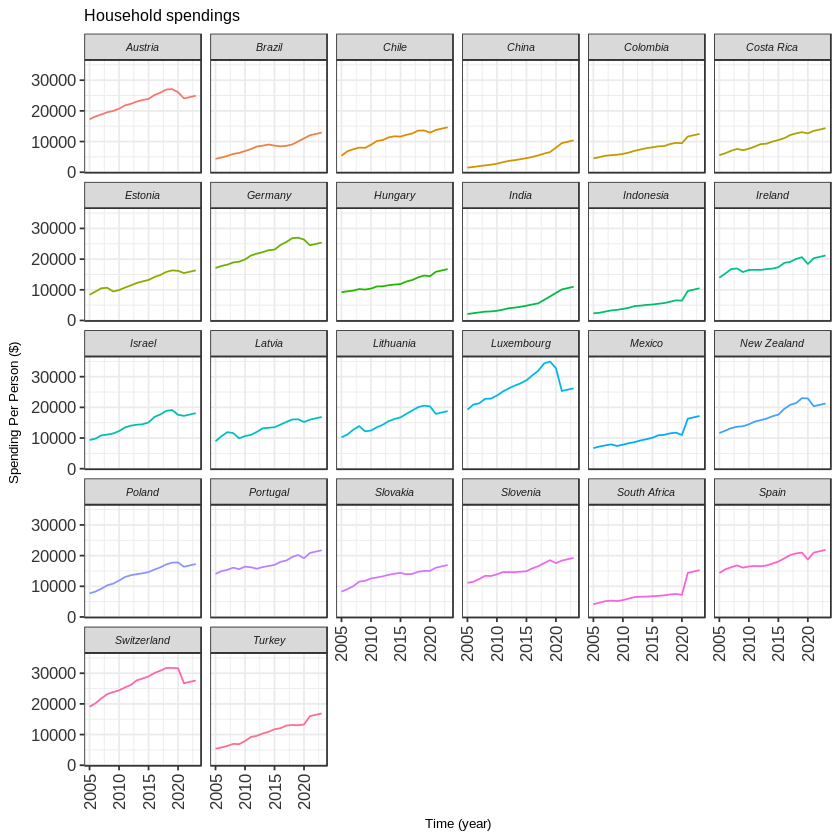

In [8]:
# Create a linear regression model 
model = lm(PerPersonSpending ~ TIME.y + LOCATION, data = df_spending_per_household) #Create the linear regression

# Review the results
summary(model) 

# Use summary to filter out only significants locations(according to Pr(>|t|)) 
df_sig <- as.data.frame(summary(model)$coefficients[,])
df_sig <- cbind(newColName = rownames(df_sig), df_sig)
rownames(df_sig) <- 1:nrow(df_sig)
# rename column for merging
names(df_sig)[1] <- "LOCATION"
df_sig$LOCATION <- str_replace_all(df_sig$LOCATION, "LOCATION", "")
df_sig <- merge(df_sig, df_spending_per_household, by=c("LOCATION"))
df_sig <- df_sig[df_sig$'Pr(>|t|)' < 0.01 | df_sig$LOCATION == "DEU", ]

# Get only neccessary columns for further processing
df_hs <- df_sig[c("LOCATION", "Country", "TIME.y", "PerPersonSpending")]

# To avoid duplicates
LOCATION <- unique(df_hs$LOCATION, incomparables = FALSE)

# Create a empty row/data set for all locations and 2021
df_2021 <- data.frame(LOCATION, Country='', TIME.y=2021, PerPersonSpending='')
# Predict Per Person Spendings for 2021
df_2021$PerPersonSpending <- predict(model, df_2021)
# Append it to the data frame
df_hs <- rbind(df_hs, df_2021)

# Create a empty row/data set for all locations and 2022
df_2022 <- data.frame(LOCATION, Country='', TIME.y=2022, PerPersonSpending='')
# Predict Per Person Spendings for 2022
df_2022$PerPersonSpending <- predict(model, df_2022)
# Append it to the data frame
df_hs <- rbind(df_hs, df_2022)

# Create a empty row/data set for all locations and 2023
df_2023 <- data.frame(LOCATION, Country='', TIME.y=2023, PerPersonSpending='')
# Predict Per Person Spendings for 2023
df_2023$PerPersonSpending <- predict(model, df_2023)
# Append it to the data frame
df_hs <- rbind(df_hs, df_2023)

# Merge with Country Codes to Map Alpha-3 to Country
df_hs <- merge(df_hs, df_country_codes,by=c("LOCATION"))

# Only data >= 2005 are interessting
df_hs <- subset(df_hs, TIME.y >= 2005)

ggplot(data = df_hs, mapping = aes(x = TIME.y, y = PerPersonSpending, color = Country.y)) +
    geom_line() +
    facet_wrap(vars(Country.y)) +
    labs(title = "Household spendings",
        x = "Time (year)",
        y = "Spending Per Person ($)") +
    theme_bw() +
    theme(axis.text.x = element_text(colour = "grey20", size = 10, angle = 90, hjust = 0.5, vjust = 0.5),
                        axis.text.y = element_text(colour = "grey20", size = 10),
                        strip.text = element_text(face = "italic"),
                        text = element_text(size = 8)) +
    theme(legend.position = "none")

## Perform linear regression and predict Internet Access for 2021 and 2022


Call:
lm(formula = Value ~ TIME + LOCATION, data = df_internet_access)

Residuals:
    Min      1Q  Median      3Q     Max 
-23.936  -3.631   1.156   4.639  22.957 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept) -5.807e+03  1.362e+02 -42.651  < 2e-16 ***
TIME         2.927e+00  6.774e-02  43.207  < 2e-16 ***
LOCATIONAUT -6.915e+00  3.094e+00  -2.235 0.025868 *  
LOCATIONBEL -7.314e+00  3.094e+00  -2.363 0.018474 *  
LOCATIONBRA -4.068e+01  3.266e+00 -12.458  < 2e-16 ***
LOCATIONCAN -8.947e-01  3.094e+00  -0.289 0.772587    
LOCATIONCHE  3.973e+00  3.317e+00   1.198 0.231545    
LOCATIONCHL -2.380e+01  3.572e+00  -6.663 6.91e-11 ***
LOCATIONCOL -4.851e+01  3.323e+00 -14.599  < 2e-16 ***
LOCATIONCRI -3.831e+01  3.094e+00 -12.379  < 2e-16 ***
LOCATIONCZE -1.772e+01  3.094e+00  -5.728 1.73e-08 ***
LOCATIONDEU  1.220e+00  3.094e+00   0.394 0.693673    
LOCATIONDNK  5.873e+00  3.094e+00   1.898 0.058263 .  
LOCATIONESP -1.590e+01  3.094e+00  -5.137 3.96e-0

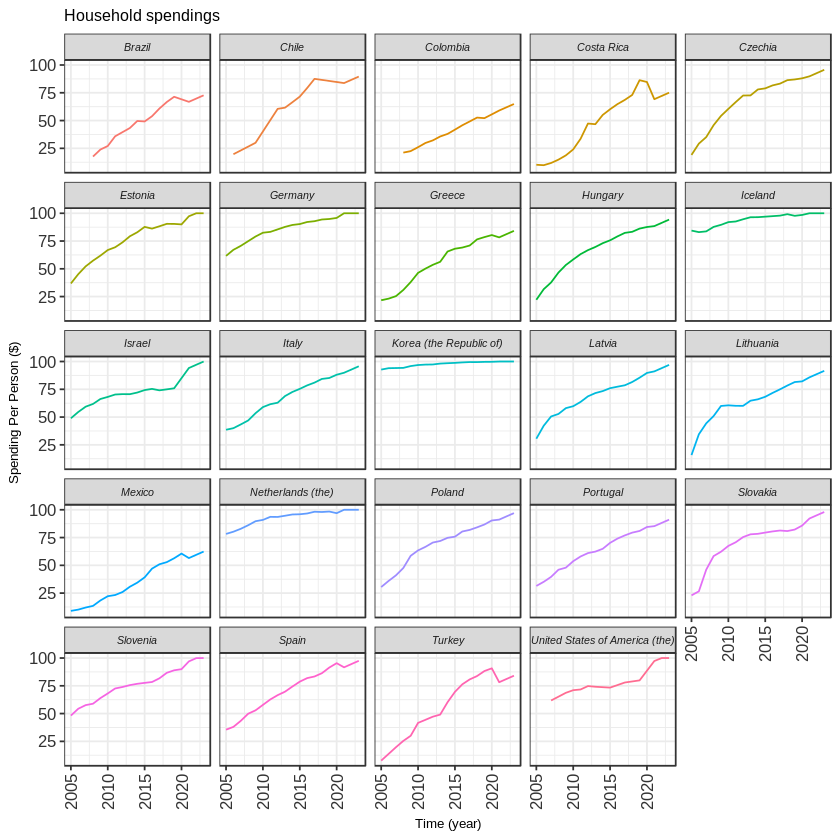

In [9]:
# Create a linear regression model 
model = lm(Value ~ TIME + LOCATION, data = df_internet_access) 

# Review the results
summary(model)

# Use summary to filter out only significants locations(according to Pr(>|t|)) 
df_sig <- as.data.frame(summary(model)$coefficients[,])
df_sig <- cbind(newColName = rownames(df_sig), df_sig)
rownames(df_sig) <- 1:nrow(df_sig)
# rename column for merging
names(df_sig)[1] <- "LOCATION"
df_sig$LOCATION <- str_replace_all(df_sig$LOCATION, "LOCATION", "")
df_sig <- merge(df_sig, df_internet_access, by=c("LOCATION"))
df_sig <- df_sig[df_sig$'Pr(>|t|)' < 0.01 | df_sig$LOCATION == "DEU", ]
#df_sig

# Get only neccessary columns for further processing
df_ia <- df_sig[c("LOCATION", "Country", "TIME", "Value")]

# To avoid duplicates
LOCATION <- unique(df_ia$LOCATION, incomparables = FALSE)

# Create a empty row/data set for all locations and 2021
df_ia2021 <- data.frame(LOCATION, Country='', TIME=2021, Value='')
# Predict Internet Access for 2021
df_ia2021$Value <- predict(model, df_ia2021)
# Append it to the data frame
df_ia <- rbind(df_ia, df_ia2021)

# Create a empty row/data set for all locations and 2022
df_ia2022 <- data.frame(LOCATION, Country='', TIME=2022, Value='')
# Predict Internet Access for 2022
df_ia2022$Value <- predict(model, df_ia2022)
# Append it to the data frame
df_ia <- rbind(df_ia, df_ia2022)

# Create a empty row/data set for all locations and 2023
df_ia2023 <- data.frame(LOCATION, Country='', TIME=2023, Value='')
# Predict Internet Access for 2022
df_ia2023$Value <- predict(model, df_ia2023)
# Append it to the data frame
df_ia <- rbind(df_ia, df_ia2023)

# Correct values to max. possible 100% 
df_ia$Value <- ifelse(df_ia$Value > 100.0, 100.0, df_ia$Value)

# Merge with Country Codes to Map Alpha-3 to Country
df_ia <- merge(df_ia, df_country_codes,by=c("LOCATION"))

# Only data with Year/TIME >= 2005 are interessting
df_ia <- subset(df_ia, TIME >= 2005)

ggplot(data = df_ia, mapping = aes(x = TIME, y = Value, color = Country.y)) +
    geom_line() +
    facet_wrap(vars(Country.y)) +
    labs(title = "Household spendings",
        x = "Time (year)",
        y = "Spending Per Person ($)") +
    theme_bw() +
    theme(axis.text.x = element_text(colour = "grey20", size = 10, angle = 90, hjust = 0.5, vjust = 0.5),
                        axis.text.y = element_text(colour = "grey20", size = 10),
                        strip.text = element_text(face = "italic"),
                        text = element_text(size = 8)) +
    theme(legend.position = "none")


# Correlation between Household Spendings (per person) and Internet Access (% of all households)

,LOCATION,CORR
,<fct>,<dbl>
5,DEU,0.9296108


,LOCATION,CORR
,<fct>,<dbl>
15,SVK,0.9827597
3,COL,0.9824099
16,SVN,0.9805430
13,POL,0.9799126
2,CHL,0.9724763
4,CRI,0.9551797
14,PRT,0.9318911
5,DEU,0.9296108
11,LVA,0.9287135


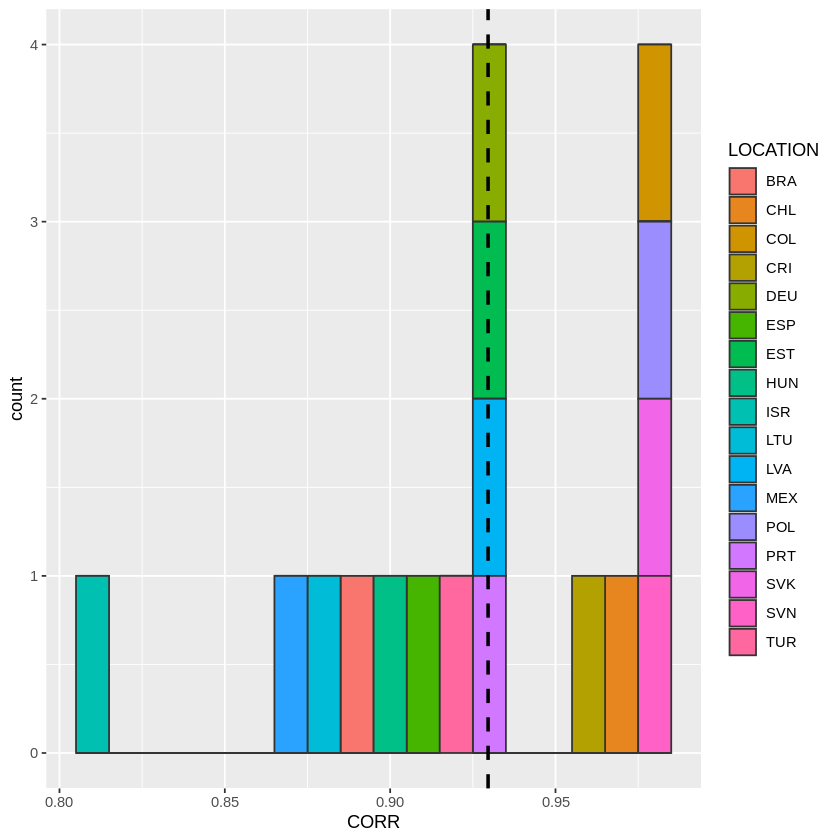

In [10]:
names(df_hs)[3] <- "TIME"

# Merge Household Spendings and Internet Access to prepare correcelations
df <- merge(df_hs, df_ia,by=c("LOCATION","TIME"))

# Group Values with Locations
xx <- data.frame(group = df$LOCATION, a = df$PerPersonSpending , b = df$Value )

# Perform Correlation for each country on a certain time span
result <- by(xx[,2:3], xx$group, function(x) {cor(x$a, x$b)})

# Coerce it into a data frame via a matrix
result.dataframe <- as.data.frame(as.matrix(result))

# Remove not usable/available rows
result.dataframe <- na.omit(result.dataframe)

# Beautify column names
result.dataframe <- cbind(newColName = rownames(result.dataframe), result.dataframe)
rownames(result.dataframe) <- 1:nrow(result.dataframe)

colnames(result.dataframe) <- c("LOCATION","CORR")

# Sort/Order the data set with decreasing correlation numbers
result.dataframe <- result.dataframe[order(result.dataframe$CORR,decreasing=TRUE), ]

# We pick germany as a reference
germany <- result.dataframe[result.dataframe$LOCATION == 'DEU', ]
View(germany)

View(result.dataframe)

ggplot(aes(x = CORR ), data = result.dataframe) + 
  geom_histogram(aes(fill = LOCATION ), binwidth=0.01, colour="grey20") +
  geom_vline(aes(xintercept=germany$CORR), color="black", linetype="dashed", size=1)


## correlation coefficients for a set of variables used to determine if a relationship exists between the variables. The coefficient indicates both the strength of the relationship as well as the direction (positive vs. negative correlations)

In [11]:
df_germany <- subset(df_hs, LOCATION == 'DEU' & TIME == 2021)
#df_germany

# Get the current exchange rate Euro/US Dollar
url <- "https://www.xe.com/currencyconverter/convert/?Amount=1&From=EUR&To=USD"
r <- GET(url)
doc <- readHTMLTable(doc=content(r, "text"))

xe <- doc[[1]]
xe <- xe[1,]

# Clean the string 
xe.dollar <- str_replace_all(xe$USD, "USD", "")
# Convert the string to double for further calculations
xe.dollar <- as.double(xe.dollar)
#xe.dollar

# German App price = 12 Euro
app.price.eur <- 12
# App Price in Dollar
app.price.dollar <- app.price.eur * xe.dollar
# Calculate the Percentage of the App Price from the per person household spendings
app.percentage.spending <- (app.price.dollar)/(df_germany$PerPersonSpending)

cat("Precentage of German Per Person Houshold Spending for App:", app.percentage.spending)

Precentage of German Per Person Houshold Spending for App: 0.0005540708

,Country,Year,AppPrice
,<fct>,<dbl>,<dbl>
200,Latvia,2022,9.107283
259,Portugal,2022,11.812755
127,Estonia,2022,8.806609
308,Turkey,2022,9.117093
101,Spain,2022,11.876066
67,Costa Rica,2022,7.709975
143,Hungary,2022,9.038672
17,Brazil,2022,6.914696
24,Chile,2022,7.873389


Final Price Suggestion for 2022 and 2023 in USD: 9.2

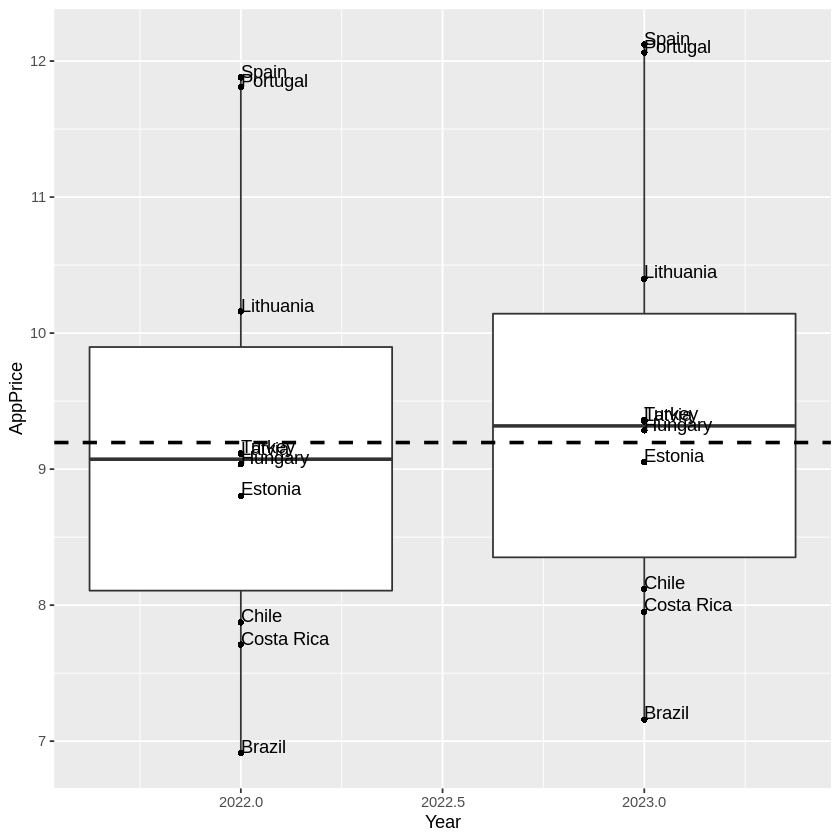

In [14]:
df_final <- merge(result.dataframe, df_hs, by=c("LOCATION"))

# Filter out similar (to Germany) Markets. Similarity in this case: Correcaltion close to German ones
df_final$Dist <- with(df_final, abs(df_final$CORR-germany$CORR))

# For all country candidates calcualte it's price in dollar
df_final$AppPrice <- with(df_final, df_final$PerPersonSpending*app.percentage.spending )

# Create Subset for 2022 
df_2022 <- subset(df_final, TIME == 2022)
# Order it (ascending)
df_2022 <- df_2022[order(df_2022$Dist), ]
# Get top 10 (closest/nearest matches)
df_2022 <- df_2022[2:11, ]

# Create Subset for 2023 
df_2023 <- subset(df_final, TIME == 2023)
# Order it (ascending)
df_2023 <- df_2023[order(df_2023$Dist), ]
# Get top 10 (closest/nearest matches)
df_2023 <- df_2023[2:11, ]

df_final <- rbind(df_2022, df_2023)
df_final <- df_final[c("Country.y","TIME", "AppPrice")]
df_final <- setNames(df_final, c("Country", "Year", "AppPrice"))
View(df_final)

g <- ggplot(df_final, aes(group=Year, y=AppPrice, x=Year)) + 
  geom_boxplot() + 
  geom_jitter(shape=16, position=position_jitter(0.0)) +
  geom_text(aes(label=Country),hjust=0, vjust=0) 
# Get Boxplot statistics to get middle value (prices for 2022 and 2023)
boxplot_stats <- layer_data(g)
# Draw a dashed line for mean(2022,2023). This is our final price suggestion!
g <- g + geom_hline(aes(yintercept=mean(boxplot_stats$middle)), color="black", linetype="dashed", size=1)
g
cat("Final Price Suggestion for 2022 and 2023 in USD:", round(mean(boxplot_stats$middle),2))